# NEMO MMB CTDO Profile data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

#import re
#from urllib.parse import urljoin
#import requests
#from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Read a pre-generated (see the other NEMO notebook) local pickle file containing a Pandas Data Frame with temperature

- Also note that there's no salinity in the original data files; so will have to use the seawater package to convert from conductivity, temp, pressure

In [3]:
pwd

'/home/mayorga/Desktop/OceanHackWeek2018/project/ohw18_profiles'

In [4]:
df = pd.read_pickle('../nemo_mmb_ctd.pkl')

In [5]:
df['datetime'] = df.index

In [6]:
df.tail()

,time,conductivity,temperature,pressure,oxygen,datetime
datetime,,,,,,
2018-08-08 04:06:11.855000019,1.533701e+09,34.8540,8.9001,21.47,3301,2018-08-08 04:06:11.855000019
2018-08-08 04:06:12.883999825,1.533701e+09,34.8533,8.8997,21.47,3301,2018-08-08 04:06:12.883999825
2018-08-08 04:06:13.912999868,1.533701e+09,34.8527,8.8990,21.48,3301,2018-08-08 04:06:13.912999868
2018-08-08 04:06:14.942000151,1.533701e+09,34.8536,8.9000,21.48,3301,2018-08-08 04:06:14.942000151
2018-08-08 04:06:15.970999956,1.533701e+09,34.8538,8.8995,21.49,3300,2018-08-08 04:06:15.970999956


In [7]:
df.dtypes

time                   float64
conductivity           float64
temperature            float64
pressure               float64
oxygen                   int64
datetime        datetime64[ns]
dtype: object

In [8]:
df.index[0], df.index[-1]

(Timestamp('2017-05-02 21:59:14'), Timestamp('2018-08-08 04:06:15.970999956'))

- Looks like the data include bad timestamps that are < 2017, going back as far as ~1972. Manually remove everything before the first valid date in 2017.
- I haven't manually resorted on time. In that setup, the "real" min and max timestamps seem to be available from df.index[0], df.index[-1]. Use these values to delete bad time periods, THEN resort on the datetime index.

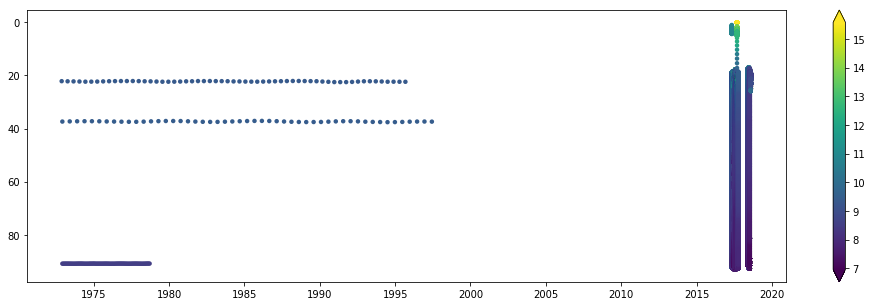

In [9]:
fig, ax = plt.subplots(figsize=(17, 5))
kw = dict(s=20, c=df['temperature'], marker='o', edgecolor='none')
#cs = ax.scatter(df['datetime'], df['pressure'], **kw)
cs = ax.scatter(df.index, df['pressure'], **kw)

ax.invert_yaxis()
#ax.set_xlim(df.index[0], df.index[-1])

cbar = fig.colorbar(cs, orientation='vertical', extend='both')

In [10]:
from datetime import timedelta
from scipy.interpolate import griddata

In [11]:
df2 = df[df.datetime > df['datetime'].iloc[0] - timedelta(days=1)].copy()

In [12]:
df2.sort_index(inplace=True)

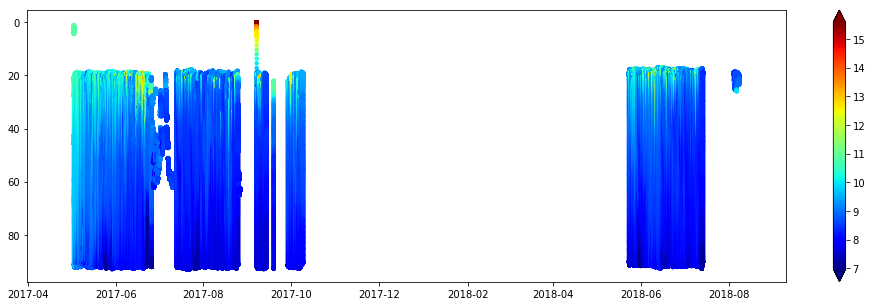

In [13]:
fig, ax = plt.subplots(figsize=(17, 5))
kw = dict(s=20, c=df2['temperature'], marker='o', edgecolor='none', cmap=plt.cm.jet)
cs = ax.scatter(df2.index, df2['pressure'], **kw)

ax.invert_yaxis()
cbar = fig.colorbar(cs, orientation='vertical', extend='both')

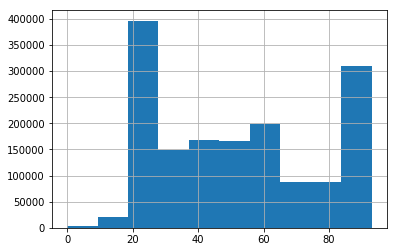

In [14]:
df2.pressure.hist();

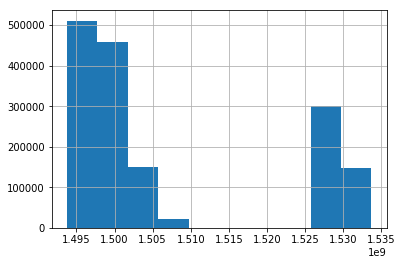

In [15]:
df2.time.hist();

## Grid the data

In [16]:
len(df), df.pressure.max(), df.time.min(), df.time.max(), df.index[0], df.index[-1], df.index.min(), df.index.max()

(1590820,
 93.0,
 90691330.0,
 1533701175.971,
 Timestamp('2017-05-02 21:59:14'),
 Timestamp('2018-08-08 04:06:15.970999956'),
 Timestamp('1972-11-15 16:02:10'),
 Timestamp('2018-08-08 04:06:15.970999956'))

In [17]:
# data coordinates and values
x = df2['time'].values / (60*60*24)
y = df2['pressure'].values
z = df2['temperature'].values

In [18]:
x.dtype, y.dtype, z.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

In [19]:
x.min(), x.max(), x.max() - x.min()

(17288.91613425926, 17751.17101818287, 462.2548839236115)

In [20]:
# target grid to interpolate to
xi = np.arange(17288, 17752, 0.25)
yi = np.arange(15, 93, 0.5)
xi,yi = np.meshgrid(xi,yi)

In [21]:
len(xi), len(yi)

(156, 156)

In [27]:
zi = griddata((x,y),z,(xi,yi), method='linear')

In [28]:
import datetime
import calendar

In [29]:
# come up with a rough start and end dt of the main data gap, 2017-18
gap_start_dt, gap_end_dt = datetime.datetime(2017, 11, 1), datetime.datetime(2018, 5, 1)
gap_start = calendar.timegm(gap_start_dt.timetuple()) / (60*60*24)
gap_end = calendar.timegm(gap_end_dt.timetuple()) / (60*60*24)

In [31]:
# set mask and mask out the field
mask = (xi > gap_start) & (xi < gap_end) & (yi > 19.9)
zi[mask] = np.nan

In [46]:
# xdti = datetime.datetime.utcfromtimestamp(xi * (60*60*24))
npa_days_to_dt = np.vectorize(lambda day: datetime.datetime.utcfromtimestamp(day * (60*60*24)))
xdti = npa_days_to_dt(xi)

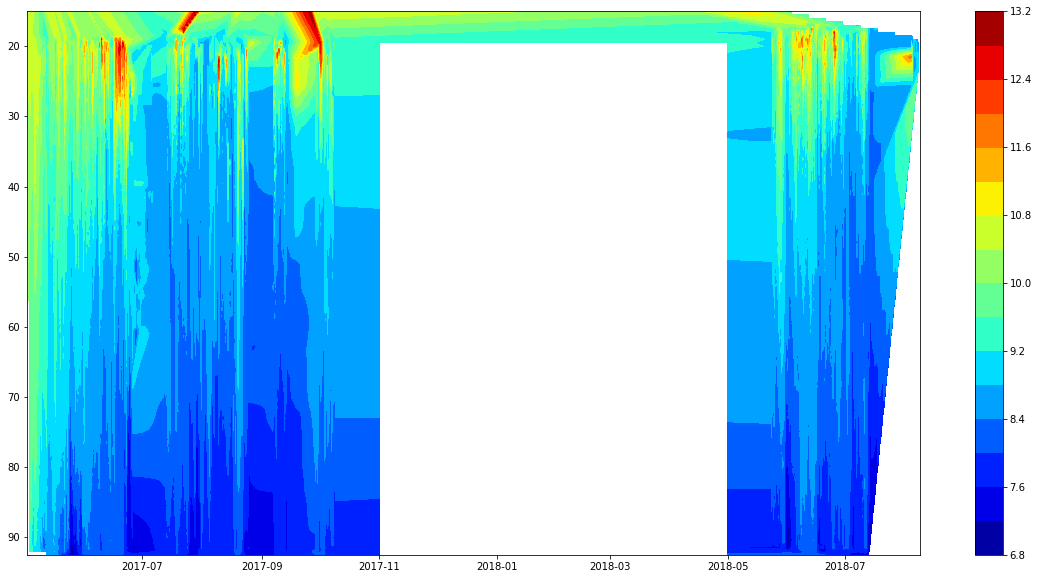

In [47]:
# plot
fig, ax = plt.subplots(1, figsize=(20,10))

# contour the gridded data, plotting dots at the randomly spaced data points.
#CS = plt.contour(xdti,yi,zi,15,linewidths=0.5,colors='k')
cs = plt.contourf(xdti,yi,zi,15,cmap=plt.cm.jet)

ax.invert_yaxis()

cbar = fig.colorbar(cs, orientation='vertical', extend='both')

# plot data points.
#plt.scatter(x,y,marker='o',c='b',s=5)

#plt.xlim(-2,2)
#plt.ylim(-2,2)
#plt.title('griddata test (%d points)' % npts)